<a href="https://mumbrella.com.au/wp-content/uploads/2013/01/Screen-Shot-2013-01-22-at-4.25.45-PM.png"><center><img src="https://assets.2ser.com/wp-content/aws/uploads/2018/02/02181138/Melbourne-VS-Sydney-990x500.png" width = 700 h></center> </a>

<h1 align=center><font size = 10>Settling the Great Australian Rivalry </font></h1>

## Introduction

In this analysis we will aim to quantify the relative strengths of both Melbourne and Sydney in the hope that we can (finally) state definitively whether Sydney is better than Melbourne.

## Table of Contents

[1. Data](#Data)  
[2. Clustering](#Clustering)

## Initialisation

Before starting the analysis, load all the required libraries.

In [130]:
# load standard libraries
import pandas as pd
import numpy as np
from math import pi

# load libraries for reading html requests
from urllib.request import Request, urlopen
import requests

# load plotting and mapping library
import matplotlib.pyplot as plt
import folium

# load modelling library
from sklearn.cluster import KMeans

# install and load library to calulate distances
#!pip install haversine
import haversine

## Data

Download the data and prepare it for the analysis.

Read in the csv of Australian postodes from Matthew Proctor (https://www.matthewproctor.com/)

In [110]:
# provide the file link
link_aus_postcodes = 'https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv'

# set a new header so website allows reading of file
df_aus_postcodes = Request(link_aus_postcodes)
df_aus_postcodes.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
df_aus_postcodes = urlopen(df_aus_postcodes)

# download file
df_aus_postcodes = pd.read_csv(df_aus_postcodes)

# show sample of results
print(df_aus_postcodes.shape)
df_aus_postcodes.head()

(18275, 14)


,id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region
0,230,200,ANU,ACT,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1
1,21820,200,Australian National University,ACT,149.118900,-35.277700,NaN,NaN,Added 19-Jan-2020,NaN,NaN,NaN,NaN,R1
2,232,800,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 6-Feb-2020,70101.0,Darwin City,701.0,Darwin,R1
3,233,801,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 25-Mar-2020 SA3,70101.0,Darwin City,701.0,Darwin,R1
4,234,804,PARAP,NT,130.873315,-12.428017,NaN,NaN,Updated 25-Mar-2020 SA3,70102.0,Darwin Suburbs,701.0,Darwin,R1


Only a subset of NSW and VIC postcodes are required.

In [111]:
# subset to NSW and VIC
df_postcodes = df_aus_postcodes[(df_aus_postcodes['state'].isin(['NSW', 'VIC']))]

# ensure the postcodes are delivery areas and in region R1 (city)
df_postcodes  = df_postcodes[(df_postcodes['region']=='R1') & 
                             (df_postcodes['type']=='Delivery Area')]

# subset to the most central postcodes for the city (ie exclude outlying suburbs)
central_postcodes_sydney = ['Sydney - City and Inner South', 
                            'Sydney - Eastern Suburbs',
                            'Sydney - Inner South West', 
                            'Sydney - Inner West']
central_postcodes_melbourne = ['Melbourne - Inner',
                               'Melbourne - Inner East', 
                               'Melbourne - Inner South', 
                               'Melbourne - West']

df_postcodes = df_postcodes[(df_postcodes['sa4name'].isin(central_postcodes_sydney)) | 
                            (df_postcodes['sa4name'].isin(central_postcodes_melbourne))]

# show sample of results
print(df_postcodes.shape)
df_postcodes.head()

(472, 14)


,id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region
689,20208,2000,BARANGAROO,NSW,151.201580,-33.860520,Sydney Metro,Delivery Area,Updated 6-Feb-2020,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South,R1
691,4479,2000,DAWES POINT,NSW,151.256649,-33.859953,WATERLOO DELIVERY FACILITY,Delivery Area,Updated 6-Feb-2020,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South,R1
692,4480,2000,HAYMARKET,NSW,151.256649,-33.859953,WATERLOO DELIVERY FACILITY,Delivery Area,Updated 6-Feb-2020,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South,R1
693,4481,2000,MILLERS POINT,NSW,151.256649,-33.859953,WATERLOO DELIVERY FACILITY,Delivery Area,Updated 6-Feb-2020,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South,R1
694,4482,2000,PARLIAMENT HOUSE,NSW,151.256649,-33.859953,WATERLOO DELIVERY FACILITY,Delivery Area,Updated 6-Feb-2020,11703.0,Sydney Inner City,117.0,Sydney - City and Inner South,R1


Keep only required data and collapse results to postcode.

In [112]:
# retain only required data
df_postcodes = df_postcodes[['postcode', 'locality', 'state', 'long', 'lat', 'sa4name']]

# some postcodes have different lat, longs so take average to standardise
df_pc_latlongs = df_postcodes.groupby('postcode')['lat', 'long'].mean().reset_index()
df_postcodes = df_postcodes[['postcode', 'locality', 'state', 'sa4name']].merge(df_pc_latlongs, how='left', on='postcode')

# create suburbs names - potentially multiple suburbs
df_postcodes['suburb'] = df_postcodes.groupby(['postcode','state','long', 'lat', 'sa4name'])['locality'].transform(lambda x: ', '.join(x))

# rename SA4 name
df_postcodes['lga'] = df_postcodes['sa4name']

# remove duplicates for postcodes
df_postcodes = df_postcodes[['postcode','suburb','lga','state','long', 'lat']].drop_duplicates().reset_index(drop=True)

# show sample of results
print(df_postcodes.shape)
df_postcodes.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


(182, 6)


,postcode,suburb,lga,state,long,lat
0,2000,"BARANGAROO, DAWES POINT, HAYMARKET, MILLERS PO...",Sydney - City and Inner South,NSW,151.249765,-33.860024
1,2006,THE UNIVERSITY OF SYDNEY,Sydney - City and Inner South,NSW,151.186507,-33.889219
2,2007,"BROADWAY, ULTIMO",Sydney - City and Inner South,NSW,151.196650,-33.883189
3,2008,"CHIPPENDALE, DARLINGTON",Sydney - City and Inner South,NSW,151.193858,-33.891146
4,2009,PYRMONT,Sydney - City and Inner South,NSW,151.193055,-33.871222


Extract the businesses and attractions in each of the postcodes, but first understand the spread of postcodes in each Local Government Area to set reasonable radii for the searches, as the geographic size of each city is different.

In [162]:
# estimate the average size of each postcode by LGA
df_sizes = df_postcodes.groupby(['state', 'lga']).agg({'state': 'count', 'lat': ['min','max'], 'long': ['min','max']}).reset_index()
df_sizes['tl'] = list(zip(df_sizes[('lat', 'max')], df_sizes[('long', 'min')])) 
df_sizes['tr'] = list(zip(df_sizes[('lat', 'max')], df_sizes[('long', 'max')])) 
df_sizes['bl'] = list(zip(df_sizes[('lat', 'min')], df_sizes[('long', 'min')])) 
df_sizes['width'] = df_sizes.apply(lambda row: haversine.haversine(row['tl'][0],row['tr'][0]), axis=1)  # km
df_sizes['height'] = df_sizes.apply(lambda row: haversine.haversine(row['tl'][0],row['bl'][0]), axis=1) # km
df_sizes['avg_area'] = df_sizes['width']*df_sizes['height']/df_sizes[('state', 'count')]                # km^2

# estimate the average radius of each postcode by lGA
df_radius = df_sizes.copy()
df_radius['avg_radius'] = 1000*(df_sizes['avg_area']/np.pi)**(1/2)                                       # m
df_radius = df_radius[['state', 'lga', 'avg_radius']]
df_radius.columns = ['state', 'count', 'lga', 'radius']
df_radius = df_radius[['lga', 'radius']]

# display calculated radii
df_radius

,lga,radius
0,Sydney - City and Inner South,1116.630733
1,Sydney - Eastern Suburbs,1143.492966
2,Sydney - Inner South West,1479.142526
3,Sydney - Inner West,1202.087786
4,Melbourne - Inner,1087.693641
5,Melbourne - Inner East,1585.391794
6,Melbourne - Inner South,1955.472186
7,Melbourne - West,3267.340677


Display the postcodes for each of the cities independently, with radius.

In [163]:
# add radius to postcode data and calculate centres for Sydney and Melbourne
df_postcodes = df_postcodes.merge(df_radius, how='left')
syd_lat_lon = [df_postcodes[df_postcodes['state']=='NSW']['lat'].mean(), 
               df_postcodes[df_postcodes['state']=='NSW']['long'].mean()]
mel_lat_lon = [df_postcodes[df_postcodes['state']=='VIC']['lat'].mean(), 
               df_postcodes[df_postcodes['state']=='VIC']['long'].mean()]
print()
print(f'Sydney centre: {syd_lat_lon}')
print(f'Melbourne centre: {mel_lat_lon}')
print()
df_postcodes.head()


Sydney centre: [-33.909083297902875, 151.1511261108014]
Melbourne centre: [-37.83067081710809, 144.95407667383336]



,postcode,suburb,lga,state,long,lat,radius
0,2000,"BARANGAROO, DAWES POINT, HAYMARKET, MILLERS PO...",Sydney - City and Inner South,NSW,151.249765,-33.860024,1116.630733
1,2006,THE UNIVERSITY OF SYDNEY,Sydney - City and Inner South,NSW,151.186507,-33.889219,1116.630733
2,2007,"BROADWAY, ULTIMO",Sydney - City and Inner South,NSW,151.196650,-33.883189,1116.630733
3,2008,"CHIPPENDALE, DARLINGTON",Sydney - City and Inner South,NSW,151.193858,-33.891146,1116.630733
4,2009,PYRMONT,Sydney - City and Inner South,NSW,151.193055,-33.871222,1116.630733


In [38]:
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=syd_lat_lon, zoom_start=12)

# get Sydney data
df_syd = df_postcodes[df_postcodes['state']=='NSW']

# add colours to each lga
lga_syd = set(list(df_syd['lga']))
colours = ['red', 'green', 'blue', 'yellow']
lga_syd = dict(zip(lga_syd, colours))

# add markers to map
for lat, lng, lga, pc, suburb, radius in zip(df_syd['lat'], df_syd['long'], df_syd['lga'], df_syd['postcode'], df_syd['suburb'], df_syd['radius']):
    label = f'{pc} ({lga}): {suburb}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=lga_syd[lga],
        fill=True,
        fill_color=lga_syd[lga],
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)  
    folium.Circle([lat, lng],
                    radius=radius,
                  color=lga_syd[lga]
                   ).add_to(map_sydney)

# display map
map_sydney

In [37]:
# create map of Melbourne using latitude and longitude values
map_melbourne = folium.Map(location=mel_lat_lon, zoom_start=12)

# get Sydney data
df_mel = df_postcodes[df_postcodes['state']=='VIC']

# add colours to each lga
lga_mel = set(list(df_mel['lga']))
colours = ['red', 'green', 'blue', 'yellow']
lga_mel = dict(zip(lga_mel, colours))

# add markers to map
for lat, lng, lga, pc, suburb, radius in zip(df_mel['lat'], df_mel['long'], df_mel['lga'], df_mel['postcode'], df_mel['suburb'], df_mel['radius']):
    label = f'{pc} ({lga}): {suburb}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=lga_mel[lga],
        fill=True,
        fill_color=lga_mel[lga],
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    folium.Circle([lat, lng],
                    radius=radius,
                  color=lga_mel[lga]
                   ).add_to(map_melbourne)

# display map
map_melbourne

Extract the businesses and attractions in each of the postcodes, taking into account the different radii for each LGA.

In [99]:
# read in credentials
cred = pd.read_csv('./FourSquare_Credentials.txt', header=0)
CLIENT_ID = cred.iloc[0, 0]
CLIENT_SECRET = cred.iloc[1, 0]
VERSION = cred.iloc[2, 0]
LIMIT = 100

In [100]:
# define function (from week three labs - modified to accept a dynamic radius)
def getNearbyVenues(names, latitudes, longitudes, radiuses):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radiuses):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print(url)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [101]:
# extract details for both cities
df_venues = getNearbyVenues(df_postcodes['postcode'], df_postcodes['lat'], df_postcodes['long'], df_postcodes['radius'])

In [104]:
# save data to csv so no need to run again
df_venues.to_csv('Venues_SydMel.csv')

In [107]:
# look at the number of venue categories
print(f"{len(df_venues['Venue Category'])} venues returned in {len(set(df_venues['Venue Category']))} categories")

11248 venues returned in 403 categories


In [24]:
# load both the venues and mapping from csv and combine
df_groups = pd.read_csv('Venues_SydMel.csv')
df_groups = df_groups.merge(pd.read_csv('VenuesGroups_SydMel.csv'), how='left')
df_groups.head()

,Unnamed: 0,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,0,2000,-33.860024,151.249765,Bradley's Head,-33.853210,151.246259,Scenic Lookout,Nature
1,1,2000,-33.860024,151.249765,Shark Island,-33.858324,151.257837,Harbor / Marina,Transport
2,2,2000,-33.860024,151.249765,Royal Motor Yacht Club,-33.867105,151.254417,Harbor / Marina,Transport
3,3,2000,-33.860024,151.249765,Duff Reserve,-33.864291,151.251022,Park,Nature
4,4,2000,-33.860024,151.249765,Royal Prince Edward Yacht Club,-33.865280,151.253120,Harbor / Marina,Transport


In [25]:
# remove initial column - the index from a previous data frame
df_groups = df_groups[list(df_groups.columns)[1:]]
df_groups.head()

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,2000,-33.860024,151.249765,Bradley's Head,-33.853210,151.246259,Scenic Lookout,Nature
1,2000,-33.860024,151.249765,Shark Island,-33.858324,151.257837,Harbor / Marina,Transport
2,2000,-33.860024,151.249765,Royal Motor Yacht Club,-33.867105,151.254417,Harbor / Marina,Transport
3,2000,-33.860024,151.249765,Duff Reserve,-33.864291,151.251022,Park,Nature
4,2000,-33.860024,151.249765,Royal Prince Edward Yacht Club,-33.865280,151.253120,Harbor / Marina,Transport


Perform a check of the data to ensure all records have a group assigned and clean if required.

In [26]:
# check for missing data
df_groups[df_groups['Venue Group'].isnull()]

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
13,2006,-33.889219,151.186507,Handcraft Specialty Coffee,-33.892643,151.185726,Café,NaN
14,2006,-33.889219,151.186507,Ralph's Cafe,-33.887722,151.186230,Café,NaN
15,2006,-33.889219,151.186507,Brewtown Newtown,-33.893849,151.182478,Café,NaN
22,2006,-33.889219,151.186507,IRO Café,-33.887800,151.180170,Café,NaN
32,2006,-33.889219,151.186507,Goose Bakery Cafe,-33.882750,151.182300,Café,NaN
...,...,...,...,...,...,...,...,...
11186,3207,-37.832179,144.918044,The Naked Egg,-37.817323,144.890830,Café,NaN
11190,3207,-37.832179,144.918044,Birds of a Feather,-37.842749,144.883704,Café,NaN
11205,3335,-37.716313,144.666692,STREAT RMIT,-37.734609,144.670931,Café,NaN
11208,3335,-37.716313,144.666692,Roadhaven Cafe,-37.739032,144.680085,Café,NaN


In [27]:
# all missing are cafes - due to an encoding issue; set group to category
df_groups.loc[df_groups['Venue Group'].isnull(), 'Venue Group'] = df_groups.loc[df_groups['Venue Group'].isnull(), 'Venue Category']

# look at categories in cafe group
set(df_groups[df_groups['Venue Group'].str[:3]=='Caf']['Venue Category'])

{'Café', 'Gaming Cafe', 'Tea Room'}

In [29]:
# look at final data
df_groups.shape

(11248, 8)

## Clustering

Cluster the data using the venue groups so that each postcode can be idenified by it's characteristics.

Start by restructuring the data so that Venue Groups are represented by columns.

In [35]:
# onehot encode for venue group
syd_mel_onehot = pd.get_dummies(df_groups[['Venue Group']], prefix="", prefix_sep="")
syd_mel_onehot = df_groups[['Postcode']].merge(syd_mel_onehot, left_index=True, right_index=True)

# take the average rate of venue group per post code
syd_mel_chars = syd_mel_onehot.groupby('Postcode').mean().reset_index()
print(syd_mel_chars.shape)
syd_mel_chars.head()

(182, 18)


,Postcode,Accomodation,Café,Commercial,Cultural,Education,Entertainment,Fast Food,Finance,Government,International Cuisine,Medical,Nature,Religious,Restaurant,Retail,Sport,Transport
0,2000,0.00,0.00,0.00,0.10,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.40,0.0,0.00,0.00,0.00,0.50
1,2006,0.00,0.16,0.02,0.04,0.0,0.17,0.03,0.0,0.00,0.24,0.01,0.02,0.0,0.03,0.26,0.02,0.00
2,2007,0.04,0.13,0.02,0.03,0.0,0.14,0.04,0.0,0.00,0.24,0.02,0.04,0.0,0.04,0.17,0.09,0.00
3,2008,0.02,0.21,0.02,0.05,0.0,0.22,0.02,0.0,0.00,0.14,0.00,0.03,0.0,0.05,0.20,0.04,0.00
4,2009,0.06,0.11,0.00,0.04,0.0,0.10,0.04,0.0,0.01,0.22,0.00,0.08,0.0,0.12,0.15,0.05,0.02


Explore the characteristics of Sydney city center (2000) and Melbourne city centre (3000).

In [45]:
# create function to "explore" postal codes (from week three work, with modifications)
def explore_pc(df_chars, postal_code, topn=5, display=0):
    chars = df_chars[df_chars['Postcode'] == postal_code].T.reset_index()
    chars.columns = ['Group','Penetration']
    chars = chars.iloc[1:]
    # penetration = percent of venues in pc of given category
    chars['Penetration'] = 100.0*chars['Penetration'].astype(float) 
    chars = chars.round({'Penetration': 1})
    top_categories = chars.sort_values('Penetration', ascending=False).reset_index(drop=True).head(topn)
    # if display requested then print results
    if display==1:
        print("----"+str(postal_code)+"----")
        print(top_categories)
        print('\n')
    # for use in profiling
    return(top_categories)

In [46]:
# Sydney
print()
print('Sydney City')
explore_pc(sy_mel_chars, 2000, topn=10, display=1);

# Sydney
print()
print('Melbourne City')
explore_pc(sy_mel_chars, 3000, topn=10, display=1);


Sydney City
----2000----
                   Group  Penetration
0              Transport         50.0
1                 Nature         40.0
2               Cultural         10.0
3  International Cuisine          0.0
4                  Sport          0.0
5                 Retail          0.0
6             Restaurant          0.0
7              Religious          0.0
8                Medical          0.0
9           Accomodation          0.0



Melbourne City
----3000----
                   Group  Penetration
0                 Retail         29.0
1  International Cuisine         24.0
2          Entertainment         16.0
3                   Café         11.0
4              Fast Food          8.0
5                  Sport          3.0
6               Cultural          3.0
7             Government          2.0
8                 Nature          1.0
9             Restaurant          1.0




In [47]:
# create profile of each post code using top 5 groups
top_n = 5
syd_mel_profile = []
suffix = ['st', 'nd', 'rd']+['th']*top_n

# get top 5 categories for each postal code
for pc in list(syd_mel_chars['Postcode']):
    topn = explore_pc(syd_mel_chars, pc, topn=top_n)
    topn = [pc]+list(topn['Group'])
    syd_mel_profile.append(topn)
    
# convert results to dataframe
syd_mel_profile = pd.DataFrame(syd_mel_profile)
syd_mel_profile.columns = ['Postcode'] + [f'{str(x+1)}{suffix[x]} Most Common Category' for x in range(top_n)]
    
syd_mel_profile

,Postcode,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category
0,2000,Transport,Nature,Cultural,International Cuisine,Sport
1,2006,Retail,International Cuisine,Entertainment,Café,Cultural
2,2007,International Cuisine,Retail,Entertainment,Café,Sport
3,2008,Entertainment,Café,Retail,International Cuisine,Cultural
4,2009,International Cuisine,Retail,Restaurant,Café,Entertainment
...,...,...,...,...,...,...
177,3207,Retail,Entertainment,International Cuisine,Café,Nature
178,3335,Café,Transport,Sport,Retail,Fast Food
179,3337,International Cuisine,Sport,Retail,Fast Food,Nature
180,3338,Retail,Sport,Fast Food,Transport,International Cuisine


To better understand the groups of postcode in each city, they will be clustered based on the distributions of categories seen in them.

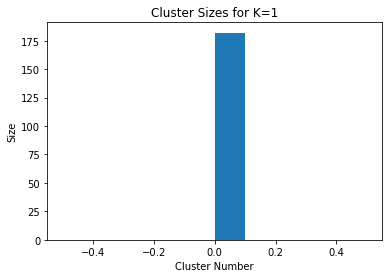

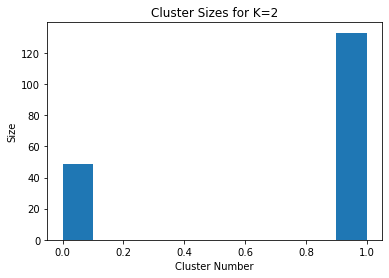

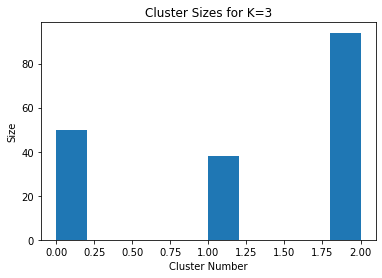

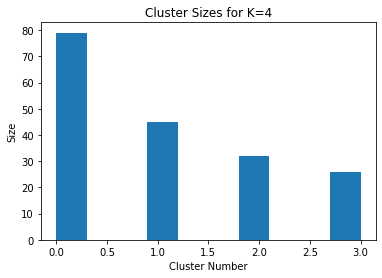

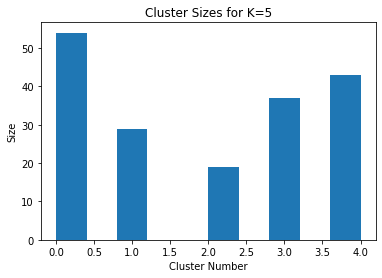

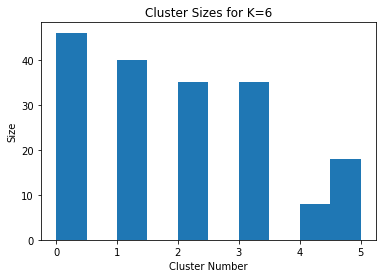

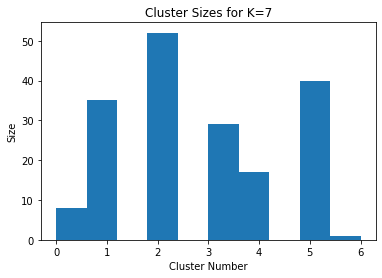

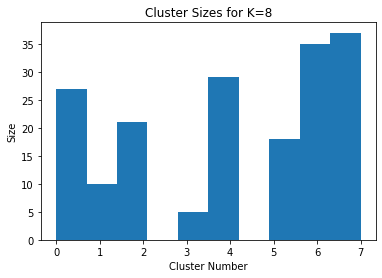

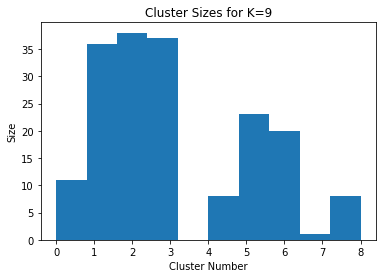

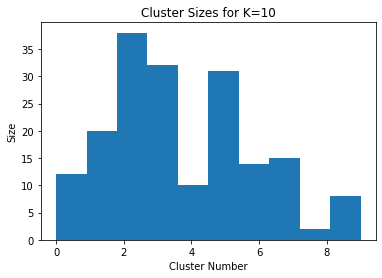

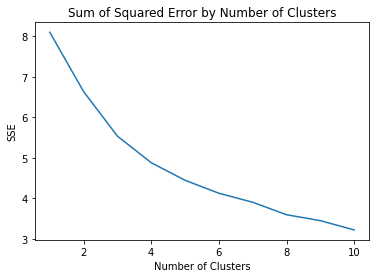

In [170]:
# loop through various numbers of clusters to see cluster distribution
max_k = 10
sse = {}
for kclusters in range(1,max_k+1):

    # run k-means clustering
    syd_mel_cluster = syd_mel_chars[syd_mel_chars.columns[1:]]
    syd_mel_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(syd_mel_cluster)

    # check cluster sizes generated
    plt.hist(syd_mel_kmeans.labels_)
    plt.title(f'Cluster Sizes for K={kclusters}')
    plt.xlabel("Cluster Number")
    plt.ylabel("Size")
    plt.show()
    
    # get measure of cluster quality
    sse[kclusters] = syd_mel_kmeans.inertia_
    
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title(f'Sum of Squared Error by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

Using the 'elbow' method, let's use k=4 fopr our clustering as there is no significnat reduction in SSE past this point. This laso produces four clusters, each of which contains a reasonable number of postcodes.

Let's create four clusters and try to interpret them.

In [100]:
# run k-means clustering for k=4
syd_mel_cluster = syd_mel_chars[syd_mel_chars.columns[1:]]
syd_mel_kmeans = KMeans(n_clusters=4, random_state=0).fit(syd_mel_cluster)

# combine segment label and input data and profile each segment
syd_mel_segments = pd.DataFrame(syd_mel_kmeans.labels_, columns=['Segment']).reset_index(drop=True).join(syd_mel_chars.reset_index(drop=True))
syd_mel_segments = syd_mel_segments.groupby('Segment').mean()
syd_mel_segments = syd_mel_segments[syd_mel_segments.columns[1:]].reset_index()
syd_mel_segments.columns = ['Postcode'] + list(syd_mel_segments.columns[1:]) # rename segment as postcode so can reuse code
segment_profile = []
for segment in list(syd_mel_segments['Postcode']):
    topn = explore_pc(syd_mel_segments, segment, topn=5)
    topn = [segment]+list(topn['Group'])
    segment_profile.append(topn)
syd_mel_segments.columns = ['Segment'] + list(syd_mel_segments.columns[1:])
segment_profile = pd.DataFrame(segment_profile)
segment_profile.columns = ['Segment'] + [f'{str(x+1)}{suffix[x]} Most Common Category' for x in range(top_n)]
segment_profile

,Segment,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category
0,0,Retail,International Cuisine,Café,Entertainment,Sport
1,1,International Cuisine,Retail,Café,Sport,Fast Food
2,2,Retail,International Cuisine,Fast Food,Sport,Café
3,3,Café,Nature,Sport,Retail,International Cuisine


In [101]:
# show average penetration for each segment
syd_mel_segments

,Segment,Accomodation,Café,Commercial,Cultural,Education,Entertainment,Fast Food,Finance,Government,International Cuisine,Medical,Nature,Religious,Restaurant,Retail,Sport,Transport
0,0,0.010485,0.203800,0.006801,0.018478,0.000380,0.108564,0.043618,0.000452,0.003906,0.205960,0.001794,0.047469,0.000215,0.047949,0.220082,0.056318,0.023731
1,1,0.007900,0.124047,0.003262,0.006447,0.001379,0.051326,0.060740,0.000000,0.001059,0.330051,0.001045,0.054514,0.000000,0.028132,0.225747,0.073750,0.030602
2,2,0.007843,0.073309,0.016923,0.004849,0.000000,0.042028,0.132696,0.000000,0.000000,0.137110,0.000460,0.043433,0.000332,0.023969,0.361499,0.098585,0.056963
3,3,0.010125,0.177123,0.000000,0.023001,0.000000,0.049112,0.051093,0.000000,0.002410,0.108899,0.001642,0.145233,0.000574,0.059541,0.133966,0.139779,0.097501


Looking at the profiles (in combination with the penetrations) of the identified segments we can class them as follows:
1. Retail and Entertainment
2. International Cuisine
3. High Volume Retail
4. Nature and Sport

Apply these classifications to each postcode.

In [114]:
# apply classification names
segment_names = ['Retail and Entertainment', 'International Cuisine', 'High Volume Retail', 'Nature and Sport']
syd_mel_final = pd.DataFrame(syd_mel_kmeans.labels_, columns=['Segment']).reset_index(drop=True).join(syd_mel_chars.reset_index(drop=True))
syd_mel_final['Classification'] = [segment_names[x] for x in syd_mel_final['Segment']]
syd_mel_final = syd_mel_final[['Postcode', 'Classification']]
syd_mel_final.columns = ['postcode', 'classification']

# add classification to postcode data
df_final = df_postcodes.merge(syd_mel_final, how='left')
df_final

,postcode,suburb,lga,state,long,lat,classification
0,2000,"BARANGAROO, DAWES POINT, HAYMARKET, MILLERS PO...",Sydney - City and Inner South,NSW,151.249765,-33.860024,Nature and Sport
1,2006,THE UNIVERSITY OF SYDNEY,Sydney - City and Inner South,NSW,151.186507,-33.889219,Retail and Entertainment
2,2007,"BROADWAY, ULTIMO",Sydney - City and Inner South,NSW,151.196650,-33.883189,Retail and Entertainment
3,2008,"CHIPPENDALE, DARLINGTON",Sydney - City and Inner South,NSW,151.193858,-33.891146,Retail and Entertainment
4,2009,PYRMONT,Sydney - City and Inner South,NSW,151.193055,-33.871222,Retail and Entertainment
...,...,...,...,...,...,...,...
177,3207,"GARDEN CITY, PORT MELBOURNE",Melbourne - West,VIC,144.918044,-37.832179,Retail and Entertainment
178,3335,"BONNIE BROOK, GRANGEFIELDS, PLUMPTON, ROCKBANK...",Melbourne - West,VIC,144.666692,-37.716313,Nature and Sport
179,3337,"HARKNESS, KURUNJANG, MELTON, MELTON WEST, TOOL...",Melbourne - West,VIC,144.566415,-37.656294,International Cuisine
180,3338,"BROOKFIELD, COBBLEBANK, EXFORD, EYNESBURY, MEL...",Melbourne - West,VIC,144.578605,-37.713162,High Volume Retail


Review each city based on the types of postcodes found in the city.

In [158]:
# define plot_radar (from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/ - with modifications)
def plot_radar(df, group):
    
    # ------- PART 1: Create background
 
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40], ["10","20","30","40"], color="grey", size=7)
    plt.ylim(0,50)


    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values=df.loc[0].drop(group).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.loc[0][group])
    ax.fill(angles, values, 'b', alpha=0.1)

    # Ind2
    values=df.loc[1].drop(group).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.loc[1][group])
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add Title
    plt.title('Comparison of Sydney and Melbourne by Postcode Profile\n')

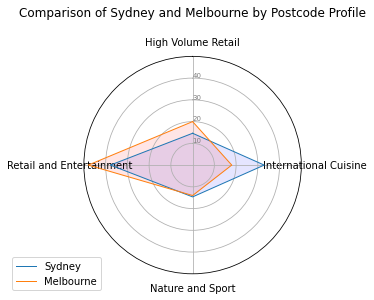

In [159]:
# summarise 
df_summary = df_final.groupby(['state', 'classification'])['postcode'].count().reset_index()
df_summary = df_summary.merge(df_final.groupby(['state'])['postcode'].count().reset_index(), how='left', on='state')
df_summary['percent'] = 100*df_summary['postcode_x']/df_summary['postcode_y']
df_summary = df_summary[['state', 'classification', 'percent']].pivot(index='state', columns='classification', values='percent').reset_index()

# add city name
df_summary['city'] = 'Melbourne'
df_summary.loc[df_summary['state']=='NSW', 'city'] = 'Sydney'
df_summary = df_summary.drop(columns='state')
df_summary = df_summary[['city'] + list(df_summary.columns)[:-1]]

# plot postcode types
plot_radar(df_summary, 'city')

From the plot it can be seen that Melbourne significantly exceeds Sydney in postcodes that are High Volume Retail and Retail and Entertainment, but Sydney has double the number of postcodes dedicated to International Cuisine and there is little separating Sydney and Melbourne in Nature and Sport, with Sydney only just ahead.

Plot the types of postcode encountered in each city.


In [167]:
# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=syd_lat_lon, zoom_start=12)

# get Sydney data
df_syd = df_final[df_final['state']=='NSW']

# add colours to each lga
class_syd = set(list(df_syd['classification']))
colours = ['red', 'green', 'blue', 'yellow']
class_syd = dict(zip(class_syd, colours))

# add markers to map
for lat, lng, lga, pc, suburb, classification in zip(df_syd['lat'], df_syd['long'], df_syd['lga'], df_syd['postcode'], df_syd['suburb'], df_syd['classification']):
    label = f'{classification.upper()} - {pc} ({lga}): {suburb}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=class_syd[classification],
        fill=True,
        fill_color=class_syd[classification],
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)

# display map
map_sydney

In [168]:
# create map of Melbourne using latitude and longitude values
map_melbourne = folium.Map(location=mel_lat_lon, zoom_start=12)

# get Sydney data
df_mel = df_final[df_final['state']=='VIC']

# add colours to each lga
class_mel = set(list(df_mel['classification']))
colours = ['red', 'green', 'blue', 'yellow']
class_mel = dict(zip(class_mel, colours))

# add markers to map
for lat, lng, lga, pc, suburb, classification in zip(df_mel['lat'], df_mel['long'], df_mel['lga'], df_mel['postcode'], df_mel['suburb'], df_mel['classification']):
    label = f'{classification.upper()} - {pc} ({lga}): {suburb}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=class_mel[classification],
        fill=True,
        fill_color=class_mel[classification],
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)

# display map
map_melbourne

In Sydney, Nature and Sport postcodes tend to be located by the water, either ocean or river, whiel in Melbourne tehy have less reliance on the water. The Retail and Entertainment is clustered around the CBD, while the High Volume Retail are dotted further out in more suburban areas, for both Sydney and Melbourne. International Cuisine can be found both out west and in the east in Sydney, but is more constrained to the east in Melbourne.